# Callin Switzer
___

### 24 Sept 2019
### - Train and prune a Dense, Feedforward Neural Network with Keras
### - Use data that was generated in Python

___

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.ticker import ScalarFormatter
import os
import pandas as pd
import time
from datetime import datetime
import sys
import seaborn as sns
import scipy.io
import subprocess
import winsound
import pickle
import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
print("TensorFlow successfully installed.")
if tf.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")
print(sys.version, "\n")
now = datetime.now()
print("last run on " + str(now))

# define directories
baseDir = os.getcwd()
dataDir = r'D:\MothSimulations\11c-AggressiveManeuver\Qstore\hws_am_con'
figDir = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\Figs'
dataOutput = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\DataOutput'
savedModels = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\savedModels'
dataDir = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\data'
if not os.path.exists(figDir):
    os.mkdir(figDir)

if not os.path.exists(dataOutput):
    os.mkdir(dataOutput)
if not os.path.exists(savedModels):
    os.mkdir(savedModels)


C:\Users\calli\Anaconda3\envs\deeplearning\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow successfully installed.
The installed version of TensorFlow includes GPU support.
3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)] 

last run on 2019-09-25 10:39:27.174612


In [2]:
# import
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras import regularizers

# Keras callcacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K

Using TensorFlow backend.


# Make training and test set

In [3]:
# concatenate all files (only need to do this once)
# it takes a few minutes
all_files = glob.glob(os.path.join(dataDir, "*.csv"))     
df_from_each_file = (pd.read_csv(f) for f in all_files)
concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)

# check for duplicates
concatenated_df.drop_duplicates(inplace=True)
concatenated_df.shape

print(concatenated_df.shape)
concatenated_df.tail()

# save to hdf5
concatenated_df.to_hdf(os.path.join(dataOutput, "concatenatedRandomICs.h5"), key = "data")

(500000, 19)


In [4]:
# read in data
trainDF = pd.read_hdf(os.path.join(dataOutput, "concatenatedRandomICs.h5"), key = "data")

In [5]:
# double check for repeats!
np.sum(trainDF.iloc[:, [16,17,18]].duplicated()) # 0 means no repeats

0

In [6]:
print(trainDF.shape)
trainDF.head()

(500000, 19)


,x0,xf,xd0,xdf,y0,yf,yd0,ydf,theta0,thetaf,thetad0,thetadf,phi0,phif,phid0,phidf,F,alpha,tau0
0,0.0,-860.538764,-50122.042406,-37099.512049,0.0,1864.077658,112333.095649,78407.466199,1.124204,1.775187,-240.317688,-398.977940,1.676109,1.137340,223.908457,-460.120574,365925.417230,4.308596,905969.160686
1,0.0,1663.999327,98162.039550,70772.904894,0.0,-1578.437127,-91951.892590,-68471.287625,2.693406,4.812711,-200.894863,1400.049194,5.327012,8.650992,-22.632197,1415.053045,301963.993342,1.157471,-836862.125114
2,0.0,-2112.906211,-128322.658782,-88483.199912,0.0,1827.677469,108010.493730,78786.893601,0.268087,1.672884,-76.923640,463.565758,5.398761,6.408854,233.275667,427.271735,442563.311276,6.082598,-128736.343362
3,0.0,-1111.053471,-61945.461511,-51111.250941,0.0,-2178.117332,-134603.694224,-90142.071404,1.454196,5.328020,-143.582522,1517.591974,3.281781,7.010763,-243.190037,1546.588052,179536.991219,4.832508,567528.919560
4,0.0,-729.739726,-39285.280174,-34179.352246,0.0,-1031.910887,-56601.382912,-46818.328690,0.353609,-3.623116,-228.575046,389.104159,4.769991,-0.295224,-76.699950,321.156438,130307.280323,0.590567,684706.884762


In [7]:
# rename columns to be consistent with other code
trainDF.rename(columns={"x0" : "x_0", "y0" : "y_0", "phi0" : "phi_0", "theta0" : "theta_0", 
                        "xf" : "x_99", "yf" : "y_99", "phif" : "phi_99", "thetaf" : "theta_99", 
                        "xd0" : "x_dot_0", "yd0" : "y_dot_0", "phid0" : "phi_dot_0", "thetad0": "theta_dot_0", 
                        "xdf" : "x_dot_99", "ydf": "y_dot_99", "phidf": "phi_dot_99", "thetadf": "theta_dot_99", 
                        "tau0" : "tau"}, inplace=True)

In [8]:
# convert angles to sine and cosine
# cosx = np.cos(angle)
# sinx = np.sin(angle)

# # print(angle, np.arctan2(sinx, cosx))

# trainDF["cos_phi_0"] = np.cos(trainDF.phi_0)
# trainDF["sin_phi_0"] = np.sin(trainDF.phi_0)
# trainDF["cos_phi_99"] = np.cos(trainDF.phi_99)
# trainDF["sin_phi_99"] = np.sin(trainDF.phi_99)

# trainDF["sin_theta_0"] = np.sin(trainDF.theta_0)
# trainDF["cos_theta_0"] = np.cos(trainDF.theta_0)
# trainDF["sin_theta_99"] = np.sin(trainDF.theta_99)
# trainDF["cos_theta_99"] = np.cos(trainDF.theta_99)

# convert to fx and fy
trainDF["Fx"] = trainDF.F * np.cos(trainDF.alpha)
trainDF["Fy"] = trainDF.F * np.sin(trainDF.alpha)


In [9]:
# make dataset
X = trainDF.loc[:, [ "phi_0", "theta_0", 
                    "x_99", "y_99", "phi_99", "theta_99", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

Y = trainDF.loc[:, ["Fx", "Fy", "tau", "x_dot_99", "y_dot_99", 
                    "phi_dot_99", "theta_dot_99"] ]

In [10]:
X.head()

,phi_0,theta_0,x_99,y_99,phi_99,theta_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0
0,1.676109,1.124204,-860.538764,1864.077658,1.137340,1.775187,-50122.042406,112333.095649,223.908457,-240.317688
1,5.327012,2.693406,1663.999327,-1578.437127,8.650992,4.812711,98162.039550,-91951.892590,-22.632197,-200.894863
2,5.398761,0.268087,-2112.906211,1827.677469,6.408854,1.672884,-128322.658782,108010.493730,233.275667,-76.923640
3,3.281781,1.454196,-1111.053471,-2178.117332,7.010763,5.328020,-61945.461511,-134603.694224,-243.190037,-143.582522
4,4.769991,0.353609,-729.739726,-1031.910887,-0.295224,-3.623116,-39285.280174,-56601.382912,-76.699950,-228.575046


In [11]:
Y.head()

,Fx,Fy,tau,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99
0,-143775.519045,-336496.673235,905969.160686,-37099.512049,78407.466199,-460.120574,-398.977940
1,121285.802738,276535.725231,-836862.125114,70772.904894,-68471.287625,1415.053045,1400.049194
2,433689.765168,-88178.637303,-128736.343362,-88483.199912,78786.893601,427.271735,463.565758
3,21514.002933,-178243.313742,567528.919560,-51111.250941,-90142.071404,1546.588052,1517.591974
4,108236.510499,72559.252341,684706.884762,-34179.352246,-46818.328690,321.156438,389.104159


In [12]:
# test train split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state = 123)

In [13]:
# scale data 
scalerX = MinMaxScaler([-0.5, 0.5])  
scalerY = MinMaxScaler([-0.5, 0.5])  

# Don't cheat - fit only on training data
scalerX.fit(Xtrain)  
scalerY.fit(Ytrain) 

Xtrain_scaled = scalerX.transform(Xtrain)  
Ytrain_scaled = scalerY.transform(Ytrain)  

# apply same transformation to test data
Xtest_scaled = scalerX.transform(Xtest)
Ytest_scaled = scalerY.transform(Ytest)

In [14]:
pd.DataFrame(Xtrain_scaled, columns = X.columns).head()

,phi_0,theta_0,x_99,y_99,phi_99,theta_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0
0,-0.044459,-0.077471,-0.378135,-0.276599,0.011725,0.012436,-0.363804,-0.246997,0.166977,0.463921
1,-0.296392,0.033915,0.229830,-0.288629,-0.011401,0.013935,0.209107,-0.268205,0.290953,0.184129
2,0.462941,-0.375731,0.171034,0.140524,0.026247,-0.011535,0.151930,0.117742,0.232862,0.146800
3,0.131530,0.404820,0.036584,-0.332834,0.002561,0.019010,0.026978,-0.323603,-0.453282,0.353115
4,0.137024,0.151784,0.430877,0.107266,0.045268,0.039668,0.429445,0.087003,-0.308493,0.173367


In [15]:
# save scalers, to be used on test set
scalerfileX = 'scalerX.pkl'
pickle.dump(scalerX, open(os.path.join(dataOutput, scalerfileX), 'wb'))

scalerfileY = 'scalerY.pkl'
pickle.dump(scalerY, open(os.path.join(dataOutput, scalerfileY), 'wb'))

# Keras models

In [16]:
# import
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras import regularizers

# Keras callcacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K

K.clear_session()

In [17]:
# create network
def create_network(optimizer = 'rmsprop', 
                    numUnits = [400, 16], 
                    weightRegularization = 0.0, 
                    dropout_rate=0.1):
    
    '''
    Create a feed forward network.  Assumes Xtrain & Ytrain have been created and scaled
    
    Params: 
    optimizer (str): choice of optimizer
    numUnits (list): number of units in each hidden
    weightRegularization (float): between 0 and 1
    dropout_rate (float): between 0 and 1
    
    '''
    K.clear_session()
    inputs = Input(shape=(Xtrain_scaled.shape[1],))    
    
    # add layers
    for ii in np.arange(0, len(numUnits)):
        if ii >= 1: 
            x = Dense(numUnits[ii], activation='tanh', 
                      kernel_regularizer=regularizers.l1(weightRegularization))(x)

        else: 
            x = Dense(numUnits[ii], activation='tanh')(inputs)


        # add dropout
        if dropout_rate > 0: 
            x = Dropout(dropout_rate)(x)
    
    predictions = Dense(Ytrain_scaled.shape[1], activation='linear')(x)

    # create model
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss="mean_squared_error", optimizer = optimizer, metrics = ['mse'])

    return(model)

In [18]:
def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]


earlystop = EarlyStopping(monitor='val_mean_squared_error', patience=15, 
                          verbose=1, mode='auto', min_delta = 0.000001)

In [19]:
def plot_model_history(model_history, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history.history['mean_squared_error'])+1),
             model_history.history['mean_squared_error'])
    axs.plot(range(1,len(model_history.history['val_mean_squared_error'])+1),
             model_history.history['val_mean_squared_error'])
    axs.set_title('Model MSE = '+ str(format_e(model_history.history['val_mean_squared_error'][-1])))
    axs.set_ylabel('mean_squared_error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,len(model_history.history['val_mean_squared_error'])+1),
                   len(model_history.history['val_mean_squared_error'])/10)
    axs.legend(['train', 'val'], loc='best')
    plt.yscale('log') #logarithmic scale for y axis
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining_" + modelName + ".png"), dpi = 120, bbox_inches='tight')
    
    plt.show()

    
def plot_model_history_fromDict(model_history_dictionary, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history_dictionary['mean_squared_error'])+1),
             model_history_dictionary['mean_squared_error'])
    axs.plot(range(1,len(model_history_dictionary['val_mean_squared_error'])+1),
             model_history_dictionary['val_mean_squared_error'])
    axs.set_title('Model MSE = '+ str(format_e(model_history_dictionary['val_mean_squared_error'][-1])) + "\n" +  str(nzwts) + " non-zero weights")
    axs.set_ylabel('mean_squared_error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,len(model_history_dictionary['val_mean_squared_error'])+1),
                   len(model_history_dictionary['val_mean_squared_error'])/10)
    axs.legend(['train', 'val'], loc='best')
    plt.yscale('log') #logarithmic scale for y axis
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining_" + modelName + "_pruned.png"), dpi = 120, bbox_inches='tight')
        print(os.path.join(figDir, "ModelTraining_" + modelName + "_pruned.png"))
    plt.show()

___

In [20]:
# train and trim weights

In [21]:

K.clear_session()

modelParams = {"optimizer": "rmsprop", 
              "dropout_rate" : 0.0, 
               "numUnits": [200, 200, 200, 16],
               "weightRegularization": 0
              }


model = create_network(**modelParams)

modelName = ''.join('{}_{}__'.format(key[0:3].capitalize(), val) for  key, val in modelParams.items()).replace("[", "").replace("]", "").replace(", ", "_")[0:-2]
modelName  = modelName +  "_" + str(datetime.now())[0:-7].replace("-", "_").replace(" ", "__").replace(":", "_")
print(modelName)

model.summary()

Opt_rmsprop__Dro_0.0__Num_200_200_200_16__Wei_0_2019_09_25__10_39_33
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               2200      
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_4 (Dense)              (None, 16)                3216      
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 119       
Total params: 85,935
Trainable params: 85,935
Non-trainable params: 0
___

In [22]:
# start training
historyDict = {"mean_squared_error": [], 
               "val_mean_squared_error": []}

In [23]:
# train with pruning
numCuts = 1

wts = model.get_weights()
wtLengths = []
for ii in range(len(wts)):
    wtLengths.append(np.prod(wts[ii].shape))

In [24]:
# train until I have very good results
# then prune, and retrain until results are close
# change pruning rate as data get closer to 100% removed
def prune_percent_updater(x):
    logit = np.exp(x*8) / (np.exp(x*8) + 1)
    return((logit - 0.5)*2*50)


# cuts a smaller portion as the percent gets closer to 100%
cutPercent = prune_percent_updater(np.linspace(0, 1, 26))

while True:   
   
    for numEpocs in range(100):
        
        MSE_tmp = []

        history = model.fit(Xtrain_scaled, Ytrain_scaled, validation_split = 0.3, 
                            verbose = 2, batch_size=2**12, epochs = 1)

        
        # save history
        historyDict["mean_squared_error"].append(history.history["mean_squared_error"][0])
        historyDict["val_mean_squared_error"].append(history.history["val_mean_squared_error"][0])
        
        # local MSE
        MSE_tmp.append(history.history["mean_squared_error"][0])

        # set weights that are close to 0 all the way back to 0, and then retrain for one epoch
        # get nonzero weights
        wts = model.get_weights().copy()

        # set weights close to 0 to 0 (but ignore biases)
        for ii in np.arange(0, len(wts), 1):
            qants = np.percentile(np.reshape(wts[ii], -1), q = (50 - cutPercent[numCuts], 50 + cutPercent[numCuts]), )
            wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0

        # print nonzero weights
        # calculate number of nonzero weights
        nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
        print(nzwts, "of", np.sum(wtLengths), "weights retained")

        # set new weights and calculate new loss
        model.set_weights(wts)
        
        # check the change in mean squared error, and if it's not changing much, then cut out more data
        # calculate slope of loss, based on previous 5 data points
        if numEpocs > 5:
            inputData = historyDict["mean_squared_error"][-5:]

            m = np.shape(inputData)
            X = np.matrix([np.ones(m), np.arange(0, len(inputData))]).T
            y = np.matrix(np.log(inputData)).T

            # Solve for projection matrix
            intercept, slope = np.array(np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)).reshape(-1,)
            print("change in log loss:", slope)
    
            # break if slope has stopped changing or if the overall min has been surpassed
            # in the first training, it will automatically prune after 5 epochs, because the min will be passed
            if (np.abs(slope) < 0.0001) or (history.history["mean_squared_error"][0] < np.min(historyDict["mean_squared_error"][:-1])): 
                print("************************************************ PRUNING ********************************************************")
                print("************************************************ PRUNING ********************************************************")
                print("************************************************ PRUNING ********************************************************")
                model.save(os.path.join(figDir,  modelName + str(datetime.now())[0:-7].replace("-", "_").replace(" ", "__").replace(":", "_") + '_Pruned.h5'))
                break
                       
                    
    ## refref: may want to save weights before each pruning, so I can go back, if I need to
    ## refref: should I be pruning the biases too?
    
    ## keep running tally of min mse, and if we can't get back to the min, then break
#     print("Min MSE for this prune ", np.min(MSE_tmp), "______overall Min MSE ", np.min(historyDict["mean_squared_error"]))
#     if np.min(MSE_tmp) > np.min(historyDict["mean_squared_error"]):
#         print("no more gain by pruning:  STOPPING Pruning")
#         break
    
    numCuts += 1
    if numCuts >= len(cutPercent):
        break

        
        #cutPercent += 0.2
winsound.PlaySound("*", winsound.SND_ALIAS)

Train on 280000 samples, validate on 120000 samples
Epoch 1/1
 - 1s - loss: 0.0282 - mean_squared_error: 0.0282 - val_loss: 0.0255 - val_mean_squared_error: 0.0255
72300 of 85935 weights retained
Train on 280000 samples, validate on 120000 samples
Epoch 1/1
 - 0s - loss: 0.0249 - mean_squared_error: 0.0249 - val_loss: 0.0255 - val_mean_squared_error: 0.0255
72300 of 85935 weights retained
Train on 280000 samples, validate on 120000 samples
Epoch 1/1
 - 0s - loss: 0.0228 - mean_squared_error: 0.0228 - val_loss: 0.0218 - val_mean_squared_error: 0.0218
72300 of 85935 weights retained
Train on 280000 samples, validate on 120000 samples
Epoch 1/1
 - 0s - loss: 0.0209 - mean_squared_error: 0.0209 - val_loss: 0.0189 - val_mean_squared_error: 0.0189
72300 of 85935 weights retained
Train on 280000 samples, validate on 120000 samples
Epoch 1/1
 - 0s - loss: 0.0196 - mean_squared_error: 0.0196 - val_loss: 0.0173 - val_mean_squared_error: 0.0173
72300 of 85935 weights retained
Train on 280000 samp

85935 total weights
73 of 85935 weights retained
D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\Figs\ModelTraining_Opt_rmsprop__Dro_0.0__Num_200_200_200_16__Wei_0_2019_09_25__10_39_33_pruned.png


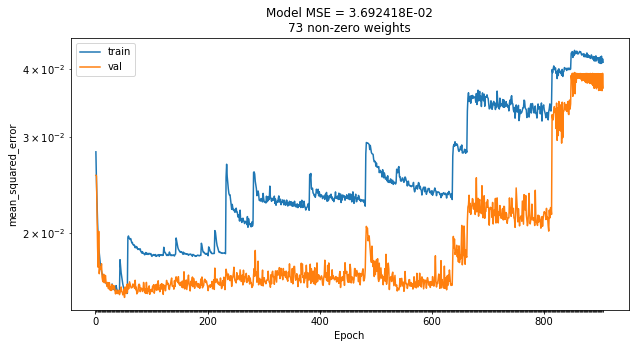

In [25]:
# print sizes of each weight matrix
wtLengths = []
for ii in range(len(wts)):
    wtLengths.append(np.prod(wts[ii].shape))

    
print(np.sum(wtLengths), "total weights")

# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
print(nzwts, "of", np.sum(wtLengths), "weights retained")
    
plot_model_history_fromDict(historyDict, saveFig = True)

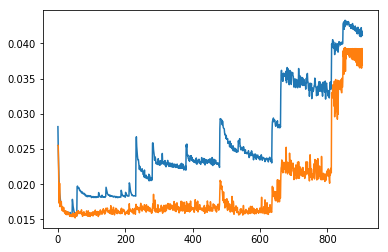

In [26]:
plt.plot(historyDict["mean_squared_error"])
plt.plot(historyDict["val_mean_squared_error"])

In [27]:
# save model
model.save(os.path.join(savedModels,  modelName + '.h5'))

# save scaler with same name as model
scalerfileX = modelName + '_scalerX.pkl'
pickle.dump(scalerX, open(os.path.join(dataOutput, scalerfileX), 'wb'))

scalerfileY = modelName + '_scalerY.pkl'
pickle.dump(scalerY, open(os.path.join(dataOutput, scalerfileY), 'wb'))

In [ ]:
# END

In [29]:
# check to see if model saved: 
K.clear_session()
from keras.models import load_model
model = load_model(os.path.join(savedModels,  modelName + '.h5'))

In [30]:
# get nonzero weights
wts = model.get_weights().copy()
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

73

In [31]:
len(wts[4])

200

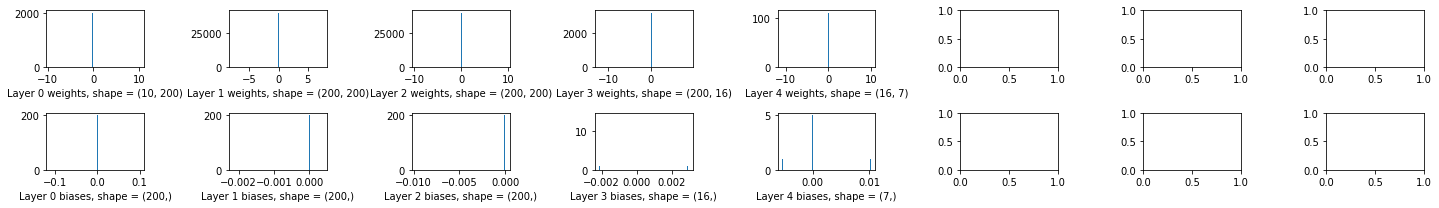

In [32]:
# show weights histograms
plt.close("all")
fig, axs = plt.subplots(2,8, figsize=np.array((20,3)) , facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)
axs = axs.ravel(order = "F")

for ii in range(int(len(wts) / 2)):  
    jj= int(2*ii)
    axs[jj].hist(wts[jj].reshape(-1), bins = 100)
    axs[jj].set_xlabel("Layer " + str(int(jj/2)) + " weights" + ", shape = " + str(wts[jj].shape))
    axs[jj+1].hist(wts[jj+1], bins = 100)
    axs[jj+1].set_xlabel("Layer " + str(int(jj/2)) + " biases" + ", shape = " + str(wts[jj+1].shape))

plt.tight_layout()
plt.show()

In [ ]:
len(model.get_weights())

In [ ]:
model.evaluate(Xtest_scaled, Ytest_scaled)

In [ ]:
# get nonzero weights
wts = model.get_weights().copy()
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

In [ ]:
# trim weights
for ii in np.arange(0, 7):
    qants = np.percentile(np.reshape(wts[ii], -1), q = (5, 95), )
    wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0
    
# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

In [ ]:
# set new weights and calculate new loss
model.set_weights(wts)

In [ ]:
ValLoss = model.evaluate(Xtrain_scaled[-int(0.05*Xtrain_scaled.shape[0]):, :], 
                         Ytrain_scaled[-int(0.05*Xtrain_scaled.shape[0]):, :])
print(ValLoss[0])

In [ ]:

wts = model.get_weights().copy()
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
print(nzwts)

# trim weights
for ii in np.arange(0, 7):
    qants = np.percentile(np.reshape(wts[ii], -1), q = (2, 98), )
    wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0
    
# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
print(nzwts)
model.set_weights(wts)


# start training
history = model.fit(Xtrain_scaled, Ytrain_scaled, validation_split = 0.3, 
                    verbose = 2, batch_size=2**14, epochs = 1, 
                    callbacks = [earlystop])

In [ ]:
wts = model.get_weights().copy()

# trim weights
for ii in np.arange(0, 7):
    qants = np.percentile(np.reshape(wts[ii], -1), q = (2.5, 97.5), )
    wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0

# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
print(nzwts)
model.set_weights(wts)

model.evaluate(Xtest_scaled, Ytest_scaled)


In [ ]:
def plot_model_history(model_history, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history.history['mean_squared_error'])+1),
             model_history.history['mean_squared_error'])
    axs.plot(range(1,len(model_history.history['val_mean_squared_error'])+1),
             model_history.history['val_mean_squared_error'])
    axs.set_title('Model MSE')
    axs.set_ylabel('mean_squared_error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,len(model_history.history['val_mean_squared_error'])+1),
                   len(model_history.history['val_mean_squared_error'])/10)
    axs.legend(['train', 'val'], loc='best')
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining.png"), dpi = 120, bbox_inches='tight')
    plt.show()
    
plot_model_history(history)
print(history.history["loss"][-1])

In [ ]:
# load model that was trained for much longer
from keras.models import load_model
model = load_model(os.path.join(savedModels, 'my_model.h5'))

In [ ]:
model.summary()

In [ ]:
# get nonzero weights
wts = model.get_weights().copy()
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

In [ ]:
# set new weights and calculate new loss
model.set_weights(wts)

ValLoss = model.evaluate(Xtrain_scaled[-int(0.05*Xtrain_scaled.shape[0]):, :], 
                         Ytrain_scaled[-int(0.05*Xtrain_scaled.shape[0]):, :])
print(ValLoss[0])

In [ ]:
wts = model.get_weights().copy()
nzwts = [np.nonzero(wts[ii].reshape(-1))[0] for ii in range(len(wts))]


In [ ]:
# show weights histograms
plt.close("all")
fig, axs = plt.subplots(2,8, figsize=np.array((20,5)) , facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace = 0.3, wspace=0.3)
axs = axs.ravel(order = "F")

for ii in range(int(len(wts) / 2)):  
    jj= int(2*ii)
    axs[jj].hist(nzwts[jj].reshape(-1), bins = 30)
    axs[jj].set_xlabel("Layer " + str(int(jj/2)) + " weights" + ", shape = " + str(nzwts[jj].shape))
    axs[jj+1].hist(nzwts[jj+1], bins = 30)
    axs[jj+1].set_xlabel("Layer " + str(int(jj/2)) + " biases" + ", shape = " + str(nzwts[jj+1].shape))

plt.tight_layout()
plt.show()

In [ ]:
# show weights histograms
plt.close("all")
fig, axs = plt.subplots(2,8, figsize=np.array((10,10)) , facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace = 0.3, wspace=0.3)
axs = axs.ravel(order = "F")

for ii in range(int(len(wts) / 2)):  
    jj= int(2*ii)
    axs[jj].hist(wts[jj].reshape(-1), bins = 30)
    axs[jj].set_xlabel("Layer " + str(int(jj/2)) + " weights" + ", shape = " + str(wts[jj].shape))
    axs[jj+1].hist(wts[jj+1], bins = 30)
    axs[jj+1].set_xlabel("Layer " + str(int(jj/2)) + " biases" + ", shape = " + str(wts[jj+1].shape))

plt.tight_layout()
plt.show()

In [ ]:
# predict on test set
nnpreds = model.predict(Xtest_scaled[ :])

# rescale
nnpreds_unscaled = scalerY.inverse_transform(nnpreds)

# show residuals
# combine residual and regular plots
plt.close("all")
fig, axs = plt.subplots(2,7, figsize=np.array((30, 8)) / 1.7, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.5)
axs = axs.ravel()

# replace lightest colors with white
import matplotlib.colors
cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(len(Y.columns)):
    
    try:
        axs[ii].hexbin(y = Ytest.iloc[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[ii].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[ii].ticklabel_format(style='sci',  axis='y', scilimits=(3,4))
        axs[ii].axes.xaxis.set_ticklabels([])
        if(ii == 0):
            axs[ii].set_ylabel("Actual Value")
        axs[ii].set_title(nms2[ii])
        axs[ii].plot(Ytest.iloc[0:1000,ii], Ytest.iloc[0:1000,ii], 'grey', linewidth = 1, linestyle  = "--")
    except:
        pass

for ii in range(len(Y.columns)):
    jj = ii + len(Y.columns)
    
    try:
        axs[jj].hexbin(y = Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[jj].set_xlabel("Predicted Value")
        axs[jj].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[jj].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        mmin = np.min(Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii])
        mmax = np.max(Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii])
        
        upper = np.max([np.abs(mmin), np.abs(mmax)])
        axs[jj].set_ylim(-upper, upper)

        if(ii == 0):
            axs[jj].set_ylabel("Actual - Predicted")
        axs[jj].hlines(y = 0, xmin = np.min(nnpreds_unscaled[:,ii]), 
                       xmax = np.max(nnpreds_unscaled[:,ii]), linestyle =  "--", linewidth = 1)
    except:
        pass
plt.tight_layout()
#fig.savefig(os.path.join(figDir, "SmallModelResids.png"), dpi = 120, bbox_inches='tight')


In [ ]:
# trim distribution of weights -- cut out middle 20%
for ii in np.arange(0, 7):
    qants = np.percentile(np.reshape(wts[ii], -1), q = (40, 60), )
    wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0
    
# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
nzwts

In [ ]:
# show new histogram of weights (excluding the 0's)
# show weights histograms
plt.close("all")
fig, axs = plt.subplots(2,5, figsize=np.array((15, 6)) , facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.3, wspace=0.3)
axs = axs.ravel(order = "F")

for ii in range(int(len(wts) / 2)):  
    jj= int(2*ii)
    
    d1 = wts[jj].reshape(-1)
    axs[jj].hist(d1[d1!=0], bins = 30, facecolor = '#d6bddb' )
    axs[jj].set_xlabel("Layer " + str(int(jj/2)) + " weights" + ", shape = " + str(wts[jj].shape))

    d2 = wts[jj+1]
    axs[jj+1].hist(d2[d2!=0], bins = 30, facecolor = '#d6bddb')
    axs[jj+1].set_xlabel("Layer " + str(int(jj/2)) + " biases" + ", shape = " + str(wts[jj+1].shape))

plt.tight_layout()
plt.show()

In [ ]:
# the validation.split is the last X% of the data
int(0.3*Xtrain_scaled.shape[0])
ValLoss = model.evaluate(Xtrain_scaled[-int(0.3*Xtrain_scaled.shape[0]):, :], 
                         Ytrain_scaled[-int(0.3*Xtrain_scaled.shape[0]):, :])
print(ValLoss[0])

In [ ]:
# set new weights and calculate new loss
model.set_weights(wts)

ValLoss = model.evaluate(Xtrain_scaled[-int(0.3*Xtrain_scaled.shape[0]):, :], 
                         Ytrain_scaled[-int(0.3*Xtrain_scaled.shape[0]):, :])
print(ValLoss[0])

In [ ]:
# predict on test set
nnpreds = model.predict(Xtest_scaled[ :])

# rescale
nnpreds_unscaled = scalerY.inverse_transform(nnpreds)

# show residuals
# combine residual and regular plots
plt.close("all")
fig, axs = plt.subplots(2,7, figsize=np.array((30, 8)) / 1.7, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=0.5)
axs = axs.ravel()

# replace lightest colors with white
import matplotlib.colors
cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

for ii in range(len(Y.columns)):
    
    try:
        axs[ii].hexbin(y = Ytest.iloc[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[ii].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[ii].ticklabel_format(style='sci',  axis='y', scilimits=(3,4))
        axs[ii].axes.xaxis.set_ticklabels([])
        if(ii == 0):
            axs[ii].set_ylabel("Actual Value")
        axs[ii].set_title(nms2[ii])
        axs[ii].plot(Ytest.iloc[0:1000,ii], Ytest.iloc[0:1000,ii], 'grey', linewidth = 1, linestyle  = "--")
    except:
        pass

for ii in range(len(Y.columns)):
    jj = ii + len(Y.columns)
    
    try:
        axs[jj].hexbin(y = Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii],x = nnpreds_unscaled[:,ii], gridsize = 150, cmap = cmap)
        axs[jj].set_xlabel("Predicted Value")
        axs[jj].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axs[jj].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        mmin = np.min(Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii])
        mmax = np.max(Ytest.iloc[:,ii] - nnpreds_unscaled[:,ii])
        
        upper = np.max([np.abs(mmin), np.abs(mmax)])
        axs[jj].set_ylim(-upper, upper)

        if(ii == 0):
            axs[jj].set_ylabel("Actual - Predicted")
        axs[jj].hlines(y = 0, xmin = np.min(nnpreds_unscaled[:,ii]), 
                       xmax = np.max(nnpreds_unscaled[:,ii]), linestyle =  "--", linewidth = 1)
    except:
        pass
plt.tight_layout()



In [ ]:
# create dict of hyperparameters


# regularization, num layers, num nodes, learning rate, optimizer, activation function, batch size

from scipy.stats import randint
from scipy.stats import uniform

# Create hyperparameter space
NumHiddenLayers = randint(low = 2, high = 20)#[4, 2, 8]
numUnits  = [2**4, 2**5, 2**6, 2**7, 2**8, 2**9, 2**10]
epochs = [200]
batches1 = [2**12, 2**10, 2**8, 2**14] 
optimizers = ['rmsprop', 'adam']
dropout_rate =  uniform(loc = 0, scale = 0.5) #[0.0, 0.2, 0.5]
weightRegularization = uniform(loc = 0, scale = 0.001) #[0, 0.0001, 0.001, 0.01]
secondToLastUnits = [8, 16, 32, 64]

# Create hyperparameter options
hyperparameters = dict(optimizer=optimizers, 
                        epochs=epochs, 
                        batch_size=batches1,
                        dropout_rate = dropout_rate, 
                        numUnits = numUnits, 
                        NumHiddenLayers = NumHiddenLayers, 
                        weightRegularization = weightRegularization, 
                        secondToLastUnits = secondToLastUnits)